# Vectorise waterbodies in an area

* **Products used:** 
[wofs_ls_summary_alltime](https://explorer.digitalearth.africa/wofs_ls_summary_alltime)

## Background

WIP

## Description
WIP

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

 To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

from pathlib import Path

import rasterio.features
from shapely.geometry import Polygon, shape, mapping, MultiPolygon
from shapely.ops import unary_union
from datacube.utils.geometry import Geometry, CRS
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math
import geohash as gh
import re
import datacube
import seaborn as sns
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs
from deafrica_tools.plotting import map_shapefile

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='DEA_notebooks_template')

In [3]:
minimum_wet_percentage = [0.001, 0.01]

In [4]:
min_area_m2 = 1
max_area_m2 = 5000000000  # approx area of Kati Thanda-Lake Eyre

In [5]:
min_valid_observations = 10

In [6]:
apply_min_valid_observations_first = True

In [7]:
handle_large_polygons = 'erode-dilate-v2'

In [8]:
# Check that's a valid method for handling.
large_polygon_options = {'erode-dilate-v1', 'erode-dilate-v2', 'nothing'}
assert handle_large_polygons in large_polygon_options

In [9]:
pp_thresh = 0.005

In [10]:
area = gpd.read_file('data/ccy.geojson')
area.head()

County ConsrvName           AreaHa  iddddd  \
0  Isiolo      Naapu  28143.325296731       1   

                                            geometry  
0  MULTIPOLYGON (((38.22535 1.47926, 38.22107 1.4...

In [12]:
geom = Geometry(geom=area.iloc[0].geometry, crs="epsg:6933")
geom

In [14]:
base_filename = 'waterbodies'

In [13]:
%%bash
rm -rf _wb_outputs
mkdir _wb_outputs

In [15]:
intermediate_wb_path = Path('_wb_outputs/')

In [16]:
# First, test whether the wetness threshold has been correctly set
if len(minimum_wet_percentage) == 2:
    print(
        f'We will be running a hybrid wetness threshold. Please ensure that the major threshold is \n'
        f'listed second, with the supplementary threshold entered first.'
        f'**You have set {minimum_wet_percentage[-1]} as the detection threshold,** \n'
        f'**with {minimum_wet_percentage[0]} set as the extent threshold.**')
elif len(minimum_wet_percentage) == 1:
    print(
        f'You have not set up the hybrid threshold option. If you meant to use this option, please \n'
        f'set this option by including two wetness thresholds in the `AtLeastThisWet` variable above. \n'
        f'The wetness threshold we will use is {minimum_wet_percentage}.')
else:
    raise ValueError(
        f'There is something wrong with your entered wetness threshold. Please enter a list \n'
        f'of either one or two numbers. You have entered {minimum_wet_percentage}. \n'
        f'See above for more information')

We will be running a hybrid wetness threshold. Please ensure that the major threshold is 
listed second, with the supplementary threshold entered first.**You have set 0.01 as the detection threshold,** 
**with 0.001 set as the extent threshold.**


In [17]:
lat, lon = 1.48, 38.22
buffer = 0.2
x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

resolution = (-30, 30)# This is the resolution of WOfS, which changes depending on which collection you use.
time_range = ('2019-01-01', '2019-01-20')

# how to chunk the dataset for use with dask
dask_chunks = {'x': 3000, 'y': 3000, 'time': 1}

In [18]:
query = {
    'x': x,
    'y': y,
    #"geopolygon": geom,
    "resolution": resolution,
    "dask_chunks": dask_chunks
}
output_crs = mostcommon_crs(dc=dc, product='wofs_ls', query=query)

# Then load the WOfS summary of clear/wet observations:
wofls = dc.load(product = 'wofs_ls', output_crs=output_crs,
               **query)#, fuse_func=wofs_fuser, collection_category='T1',
               #dask_chunks= dask_chunks)

# And set the no-data values to nan:
#wofs = wofs.where(wofs != -1)
print(wofls)

<xarray.Dataset>
Dimensions:      (time: 1402, y: 1475, x: 1485)
Coordinates:
  * time         (time) datetime64[ns] 1984-06-24T07:10:48.965038 ... 2022-02...
  * y            (y) float64 1.857e+05 1.857e+05 ... 1.415e+05 1.415e+05
  * x            (x) float64 3.91e+05 3.91e+05 3.91e+05 ... 4.355e+05 4.355e+05
    spatial_ref  int32 32637
Data variables:
    water        (time, y, x) uint8 dask.array<chunksize=(1, 1475, 1485), meta=np.ndarray>
Attributes:
    crs:           epsg:32637
    grid_mapping:  spatial_ref


In [19]:
wofs_alltime = dc.load(product='wofs_ls_summary_alltime',
               like=wofls.geobox, dask_chunks=dask_chunks)
print(wofs_alltime)

<xarray.Dataset>
Dimensions:      (time: 1, y: 1475, x: 1485)
Coordinates:
  * time         (time) datetime64[ns] 2002-12-31T23:59:59.999999
  * y            (y) float64 1.857e+05 1.857e+05 ... 1.415e+05 1.415e+05
  * x            (x) float64 3.91e+05 3.91e+05 3.91e+05 ... 4.355e+05 4.355e+05
    spatial_ref  int32 32637
Data variables:
    count_wet    (time, y, x) int16 dask.array<chunksize=(1, 1475, 1485), meta=np.ndarray>
    count_clear  (time, y, x) int16 dask.array<chunksize=(1, 1475, 1485), meta=np.ndarray>
    frequency    (time, y, x) float32 dask.array<chunksize=(1, 1475, 1485), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref


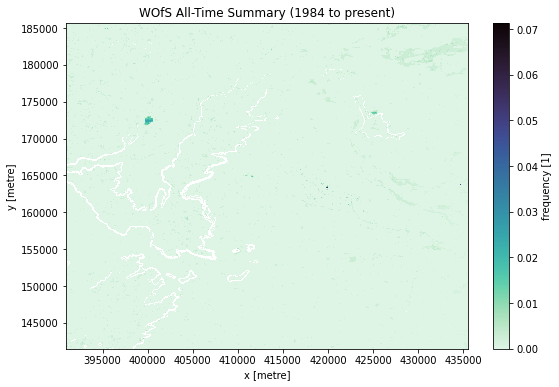

In [20]:
wofs_alltime.frequency.plot(size=6, cmap=sns.color_palette("mako_r", as_cmap=True))
plt.title('WOfS All-Time Summary (1984 to present)');

In [21]:
# Filter pixels with at least min_valid_observations times.
wofs_valid_filtered = wofs_alltime.count_clear >= min_valid_observations

In [22]:
for threshold in minimum_wet_percentage:
    # Remove any pixels that are wet < AtLeastThisWet% of the time
    wofs_filtered = wofs_alltime.frequency > threshold

    # Now find pixels that meet both the minimum valid observations and wetness percentage criteria
    # Change all zeros to NaN to create a nan/1 mask layer
    # Pixels == 1 now represent our water bodies
    if apply_min_valid_observations_first:
        wofs_filtered = wofs_filtered.where(wofs_filtered & wofs_valid_filtered)
    else:
        wofs_filtered = wofs_filtered.where(wofs_filtered)
    
    # Vectorise the raster.
    polygons = xr_vectorize((wofs_filtered == 1).values, crs='EPSG:3577', transform=wofs_alltime.rio.transform())
    polygons = polygons[polygons.attribute == 1].reset_index(drop=True)

   # Combine any overlapping polygons
    polygons = polygons.geometry.buffer(0).unary_union

    # Turn the combined multipolygon back into a geodataframe
    polygons = gpd.GeoDataFrame(
        geometry=[poly for poly in polygons])
    # We need to add the crs back onto the dataframe
    polygons.crs = 'EPSG:3577'

    # Calculate the area of each polygon again now that overlapping polygons
    # have been merged
    polygons['area'] = polygons.area
    
    # Save the polygons to a shapefile
    filename = intermediate_wb_path / f'{base_filename}_raw_{threshold}.shp'
    polygons.to_file(filename)

/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_133/648797990.py:22: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  geometry=[poly for poly in polygons])
/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare

<AxesSubplot:>

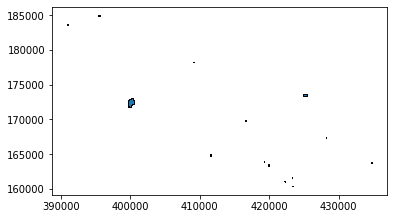

In [23]:
gpd.read_file(filename).plot(edgecolor='k')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [24]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [25]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-03-01'